# Annotators with Dynamic Labelling Performance

In [1]:
# import required packages
import sys
sys.path.append("../..")
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from annotlib import StandardAnnot
from annotlib import DynamicAnnot

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

random_state = np.random.RandomState(42)

An instance of this class emulates annotators with a dynamic labelling performance.
Therefore, it requires learning rates, which describe the progress of the labelling performance.
Such a learning rate is real number.
A learning rate of zero leads to a constant labelling accuracy.
If the learning rate is positive, the corresponding annotator's labelling performance improves during the labelling process.
In contrast, a negative learning rate results in a decreasing labelling performance.

A very important remark is the fact that the labelling performance of adversarial and non-adversarial annotators is
oppositional.
A good labelling performance implies a high labelling accuracy for a non-adversarial annotator, whereas a good
labelling performance of an adversarial annotator implies a low labelling accuracy.
There is an option, which defines whether an annotator is allowed to be adversarial.
To implement the development of the labelling performance, the predicted label of an annotator is flipped with a
probability depending on the state of the labelling progress, which is represented by the number of queries.

The flip probability is computed by $p_\text{flip}(\mu_i, q_i) = \text{min}(|\mu_i| \cdot q_i, 1)$,
where $\mu_i$ is the learning rate of an annotator $a_i$ and $q_i$ is the number of queries
processed by the annotator $a_i$.

The class [DynamicAnnot](../annotlib.dynamic.rst) offers both options to simulate dynamic annotators, so that the user decides whether adversarial annotators are allowed or not. Before showing the different options, we generate a two-dimensional (`n_features=2`) artificial data set with `n_samples=500` samples of `n_classes=4` classes.

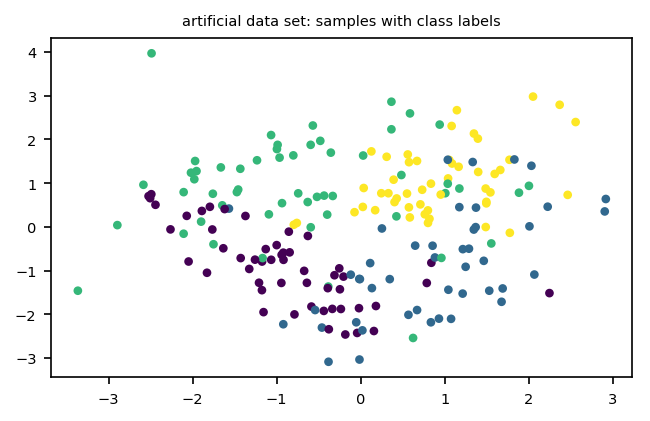

In [2]:
X, y_true =  make_classification(n_samples=200, n_features=2, 
                                 n_informative=2, n_redundant=0, 
                                 n_repeated=0, n_classes=4, 
                                 n_clusters_per_class=1, flip_y=0.1, 
                                 random_state=42)
plt.figure(figsize=(5, 3), dpi=150)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y_true, s=10)
plt.title('artificial data set: samples with class labels', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

## Dynamic Annotators without Adversarial Labelling Performances
To create an instance of the [DynamicAnnot](../annotlib.dynamic.rst) class, we need to create an instance of the [BaseAnnot](../annotlib.dynamic.rst) class being able to provide class labels. For this purpose, we exemplary create an instance of the [StandardAnnot](../annotlib.standard.rst) class. This instance comprises `n_annotators=3` annotators $\{a_0, a_1, a_2\}$, of which annotator $a_0$ is omniscient. Annotator $a_1$ labels samples randomly and annotator $a_2$ provides always false class labels. These three standard annotators are converted to dynamic annotators and their labelling accuracies are plotted along the number of queries $q_i$ processed by them.

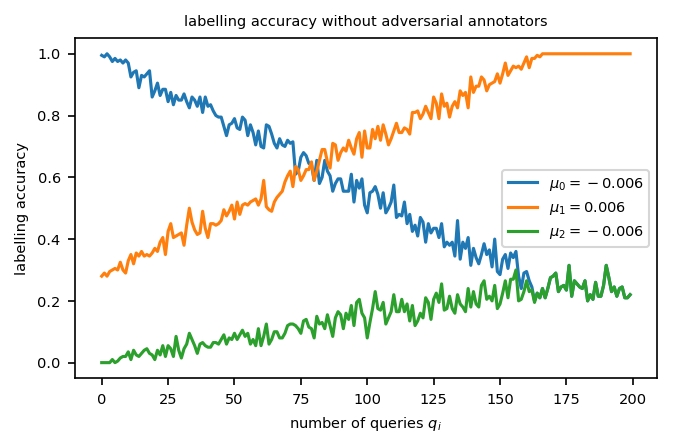

In [3]:
# create standard annotators
Y = random_state.randint(0, 3, size=len(y_true) * 3).reshape(len(y_true), 3)
Y[:, 0] = y_true
Y[:, 2] = 4
std_annot = StandardAnnot(X=X, Y=Y)
learning_rates = [-0.006, 0.006, -0.006]
y_unique = np.unique(y_true)
dyn_annot = DynamicAnnot(annotator_model=std_annot, y_unique=y_unique, 
                         learning_rates=learning_rates,
                         random_state=42)

# execute labelling process
accuracies = np.empty((len(y_true), dyn_annot.n_annotators()))
for x_idx in range(len(y_true)):
    dyn_annot.class_labels(X[x_idx].reshape(1, -1), y_true=[y_true[x_idx]], 
                            query_value=1, random_state=42)
    accuracies[x_idx, :] = dyn_annot.labelling_performance(X=X,
                                                           y_true=y_true)
    
# plot progress of labelling accuracy
plt.figure(figsize=(5, 3), dpi=150)
for a_idx in range(dyn_annot.n_annotators()):
    plt.plot(range(len(y_true)), accuracies[:, a_idx], 
             label=r'$\mu_{' + str(a_idx)+ '}=' + 
             str(learning_rates[a_idx]) + '$')

plt.xlabel(r'number of queries $q_i$', fontsize=7)
plt.ylabel('labelling accuracy', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=7)
plt.title('labelling accuracy without adversarial annotators', 
          fontsize=7)
plt.show()

The three curves in the above plot show the labelling accuracy on the whole data set after each query processed by the three annotators. Annotator $a_1$ has a positive learning rate $\mu_1=0.006$, so that the labelling accuracy of this annotator improves until the maximum of $100\%$ is reached. In contrast, annotator $a_0$ is characterised by a negative learning rate  $\mu_1=-0.006$. Hence, the labelling accuracy of this annotator decreases until a labelling accuracy, which is in the range of randomly guessing. Annotator $a_2$ is adversarial in the beginning, since the labelling accuracy is zero. But adversarial annotators are not allowed, so that the labelling accuracy of this annotator $a_2$ improves (despite negative learning rate) until the labelling accuracy is in the range of random guessing. As a result, also annotators with negative learning rates cannot be adversarial.

## Dynamic Annotators with Adversarial Labelling Performances
In order to allow annotators to be adversarial, the user changes the default input parameter from `adversarial = False` to `adversarial = True`. The corresponding result is given below, where the annotator $a_0$ has the minimal labelling accuracy of $0\%$ in the end. And the adversarial annotator $a_2$ has a constant labelling accuracy of 0.
Due to the fact that adversarial annotators are allowed, labelling accuracies can drop below the range of randomly guessing.

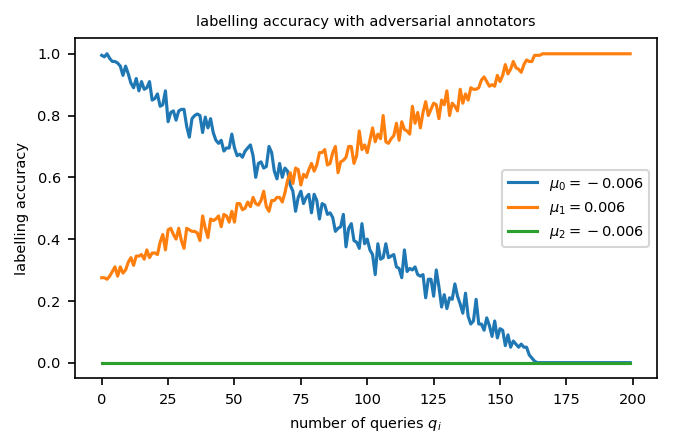

In [4]:
# create standard annotators
Y = random_state.randint(0, 3, size=len(y_true) * 3).reshape(len(y_true), 3)
Y[:, 0] = y_true
Y[:, 2] = 4
std_annot = StandardAnnot(X=X, Y=Y)
learning_rates = [-0.006, 0.006, -0.006]
y_unique = np.unique(y_true)
dyn_annot = DynamicAnnot(annotator_model=std_annot, 
                         y_unique=y_unique, 
                         learning_rates=learning_rates,
                         adversarial=True, random_state=42)

# execute labelling process
accuracies = np.empty((len(y_true), dyn_annot.n_annotators()))
for x_idx in range(len(y_true)):
    dyn_annot.class_labels(X[x_idx].reshape(1, -1), y_true=[y_true[x_idx]], 
                           query_value=1, random_state=42)
    accuracies[x_idx, :] = dyn_annot.labelling_performance(X=X, 
                                                           y_true=y_true)
    
# plot progress of labelling accuracy
plt.figure(figsize=(5, 3), dpi=150)
for a_idx in range(dyn_annot.n_annotators()):
    plt.plot(range(len(y_true)), accuracies[:, a_idx], 
             label=r'$\mu_{' + str(a_idx)+ '}=' + 
             str(learning_rates[a_idx]) + '$')
plt.xlabel(r'number of queries $q_i$', fontsize=7)
plt.ylabel('labelling accuracy', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=7)
plt.title('labelling accuracy with adversarial annotators', fontsize=7)
plt.show()

If the user does not define any learning rates manually, a learning rate is uniformly sampled from the interval $[-0.005, 0.005]$ for each annotator.